# 노드 10. 프로젝트 1: Lmage Classification

## VGG16 모델

- 문제 1-1. VGG16 모델 구현하기
        영상과 LMS 내용을 참고해 직접 코드로 구현하기.
        Batch Normalization, Parameter Initialization 등을 사용할 수도 있다.

- 문제 1-2. 다양한 방법을 사용하여 모델 성능 올리기
        skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보기.

In [4]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 캐글에서 제공되는 개와 고양이의 데이터를 불러오기
# 원하는 이미지 데이터를 불러와도 가능
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [6]:
# train 데이터와 validation 데이터를 개와 고양이가 저장된 결로를 각각 변수로 저장
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

# 고양이와 개의 train 데이터
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 고양이와 개의 validation 데이터
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# 둘 다 저장 됬는지 확인
print(train_cats_dir)
print(train_dogs_dir)
print(validation_cats_dir)
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [7]:
# train 데이터와 validation 데이터의 개수 확인
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('---')
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("---")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
---
total validation cat images: 500
total validation dog images: 500
---
Total training images: 2000
Total validation images: 1000


parameter(파라미터) 설정  
    - 수정시 성능을 높일 수 있다.

In [8]:
# 필요한 파라미터 설정
# 파라미터를 수정하면 성능을 높일 수 있음 (다양한 실험)
batch_size = 16     #128
epochs = 5          #15
IMG_HEIGHT = 256    #150
IMG_WIDTH = 256     #150

In [9]:
# 이미지를 확인하기 위한 데이터 시각화 함수 필요
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show

Data Augmentation(데이터 증강)  
    - range나 Flip에서 변화를 줘봐라

In [10]:
# train 데이터가 2천장 정도로 적기 때문에 Data Augmentation(데이터 증강)을 통해 데이터 수 증가
# Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법으로 데이터 양을 증가시켜 줌
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.3,         # 45
    width_shift_range=0.1,      # 15
    height_shift_range=0.1,     # 15
    zoom_range=0.2,             # 0.5
    horizontal_flip=True,       # False
    vertical_flip=False         # True
)

In [11]:
# .flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줌
# 지금은 개와 고양이를 분류하는 task를 수행하기 때문에 class_mode는 'binary'
# Classification task에 따라 class_mode를 변경하면 됨
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


(16, 256, 256, 3)


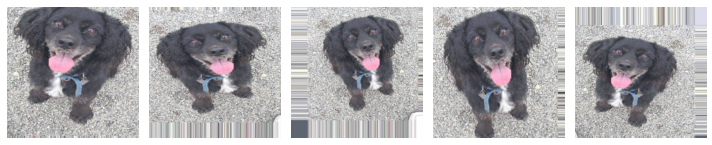

In [12]:
# Data Augmentation(데이터 증강)이 잘 적용 되었는지 확인
print(train_data_gen[0][0].shape)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
# Validation 데이터도 동일한 작업
# 하지만 calssification이 잘 되는지 평가용이기에 데이터의 스케일만 변경
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


[0. 0. 0. 1. 0.]


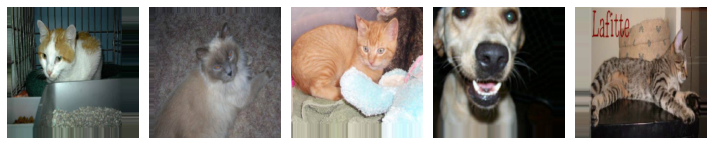

In [14]:
# Validaion 데이터 확인 / 이미지와 정답 데이터로 구성 되어있음.
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

# 고양이 : 0 / 개 : 1
print(_[:5])

### 문제 1-1. VGG16 모델 구현하기
참고 코드  
'''  
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))  
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')  (input_layer)  
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.BatchNormalization()(x)  
x=tf.keras.layers.MaxPool2D((2, 2))(x)  

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.BatchNormalization()(x)  
x=tf.keras.layers.MaxPool2D((2, 2))(x)  

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.BatchNormalization()(x)  
x=tf.keras.layers.MaxPool2D((2, 2))(x)  

x=tf.keras.layers.Flatten()(x)  
x=tf.keras.layers.Dense(1024, activation='relu')(x)  
x=tf.keras.layers.Dense(512, activation='relu')(x)  
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)  

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])  
model.summary()  
'''

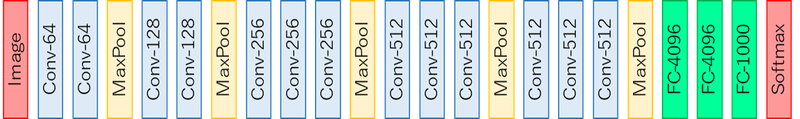

In [15]:
# 문제 1-1. 이미지에 나온 VGG16 모델 구현하기
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
# 1번째 (64)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 2번째 (128)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 3번째 (256)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 4번째 (512)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 5번째 (512)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# Flatten
x=tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

# x=tf.keras.layers.Dense(1024, activation='relu')(x)
# x=tf.keras.layers.Dense(512, activation='relu')(x)
# out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

# x = tf.keras.layers.Dense(4096, activation='relu')(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)
# x = tf.keras.layers.Dense(1000, activation='relu')(x)
# out_layer = tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

In [16]:
# 손실함수, optimizer, metric 설정
# 손실함수와 metric은 분류 task에 따라 다양하게 바뀔 수 있음.
# optimizer도 Adam 외에 다양하게 가능
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습에 활용 가능

모델 학습 시키기

data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.

In [17]:
# 모델 학습 시키기
history = model.fit(
      train_data_gen,
      steps_per_epoch=int((len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size),
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 93s 343ms/step - loss: 662.1434 - binary_accuracy: 0.5000 - val_loss: 1.0050 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 41s 328ms/step - loss: 0.7417 - binary_accuracy: 0.5000 - val_loss: 0.7594 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 42s 333ms/step - loss: 0.7196 - binary_accuracy: 0.5000 - val_loss: 0.6916 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 42s 335ms/step - loss: 0.7024 - binary_accuracy: 0.5000 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 42s 335ms/step - loss: 0.6979 - binary_accuracy: 0.5000 - val_loss: 0.7128 - val_binary_accuracy: 0.5000


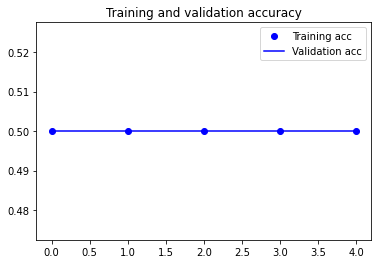

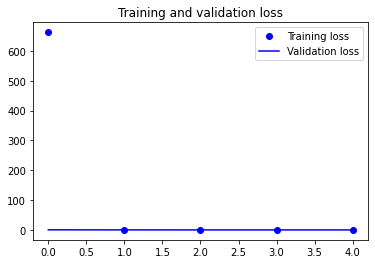

In [18]:
# 학습 결과 시각화 해서 보기
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기

hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보세요.

In [19]:
# 문제 1-2. hyperparameter 설정
batch_size = 32
epochs = 6
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [20]:
# 문제 1-2. 데이터 generator 생성
image_gen_train_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,         # 45
    width_shift_range=15,      # 15
    height_shift_range=15,     # 15
    zoom_range=0.5,             # 0.5
    horizontal_flip=True,       # False
    vertical_flip=False         # True
)

train_data_gen_2 = image_gen_train_2.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [21]:
# 문제 1-2. 모델 구현
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
# 1번째 (64)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 2번째 (128)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 3번째 (256)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 4번째 (512)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# 5번째 (512)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)
# Flatten
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 128)     1475

In [22]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.RMSprop(learning_rate=0.001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])
callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

In [23]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/6
62/62 [==============================] - 36s 474ms/step - loss: 4.6457 - binary_accuracy: 0.5060 - val_loss: 0.7198 - val_binary_accuracy: 0.5000
Epoch 2/6
62/62 [==============================] - 26s 410ms/step - loss: 0.9077 - binary_accuracy: 0.4990 - val_loss: 0.8531 - val_binary_accuracy: 0.5000
Epoch 3/6
62/62 [==============================] - 25s 393ms/step - loss: 0.7661 - binary_accuracy: 0.4940 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 4/6
62/62 [==============================] - 24s 376ms/step - loss: 0.7369 - binary_accuracy: 0.4762 - val_loss: 1.1601 - val_binary_accuracy: 0.5000
Epoch 5/6
62/62 [==============================] - 24s 374ms/step - loss: 0.7218 - binary_accuracy: 0.5079 - val_loss: 0.6966 - val_binary_accuracy: 0.5000
Epoch 6/6
62/62 [==============================] - 24s 372ms/step - loss: 0.7159 - binary_accuracy: 0.4921 - val_loss: 1.2959 - val_binary_accuracy: 0.5000


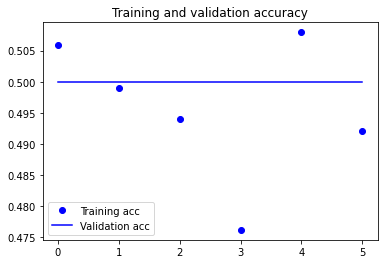

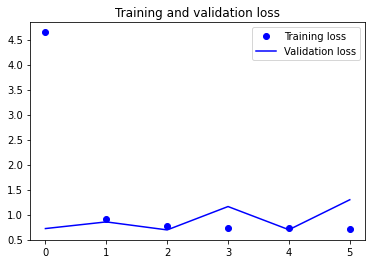

In [24]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

---

회고: 계속 오류만 뜨다가 모델 층을 바꿔보기도하고 전에 배운 부분으로 돌아봐도 왜 Validation acc 가 0.500으로 수렴하는지 이해가 안가며 돌려보다가 가면 갈 수록 머리가 하얘지고 뇌에 전기 신호가 안가서 일단 마무리를 해봅니다...

---

# 노드 10. 프로젝트 2: Object Detection

In [20]:
# 필요한 라이브러리 불러오기
!pip3 install tensorflow-estimator==2.6.0

In [21]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [22]:
# 이미지 시각화 함수
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [23]:
# 원하는 이미지를 다운로드해 정해진 가로, 세로 길이에 맞게 이미지를 resizing하는 함수
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [24]:
# Bounding Box(B-Box)를 만드는 함수
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [25]:
#이미지 위에 class 이름과 score를 나타내는 함수
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmp44rhcaq4.jpg.


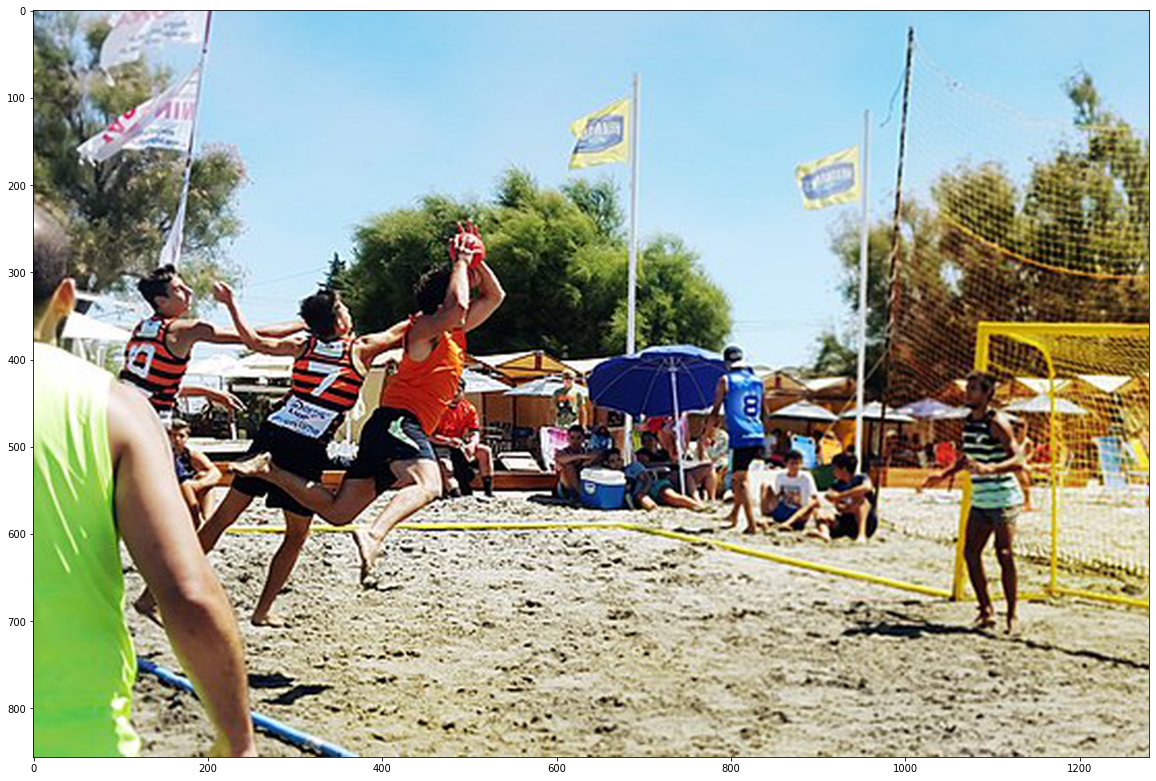

In [26]:
# 이미지 불러오기
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [34]:
# tfhub에서 사전 학습된(Pre-trained) InceptionResnet 모델을 사용한 Faster RCNN 모델을 불러오기
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [35]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [36]:
# Detector를 실행하는 함수
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  48.21046018600464


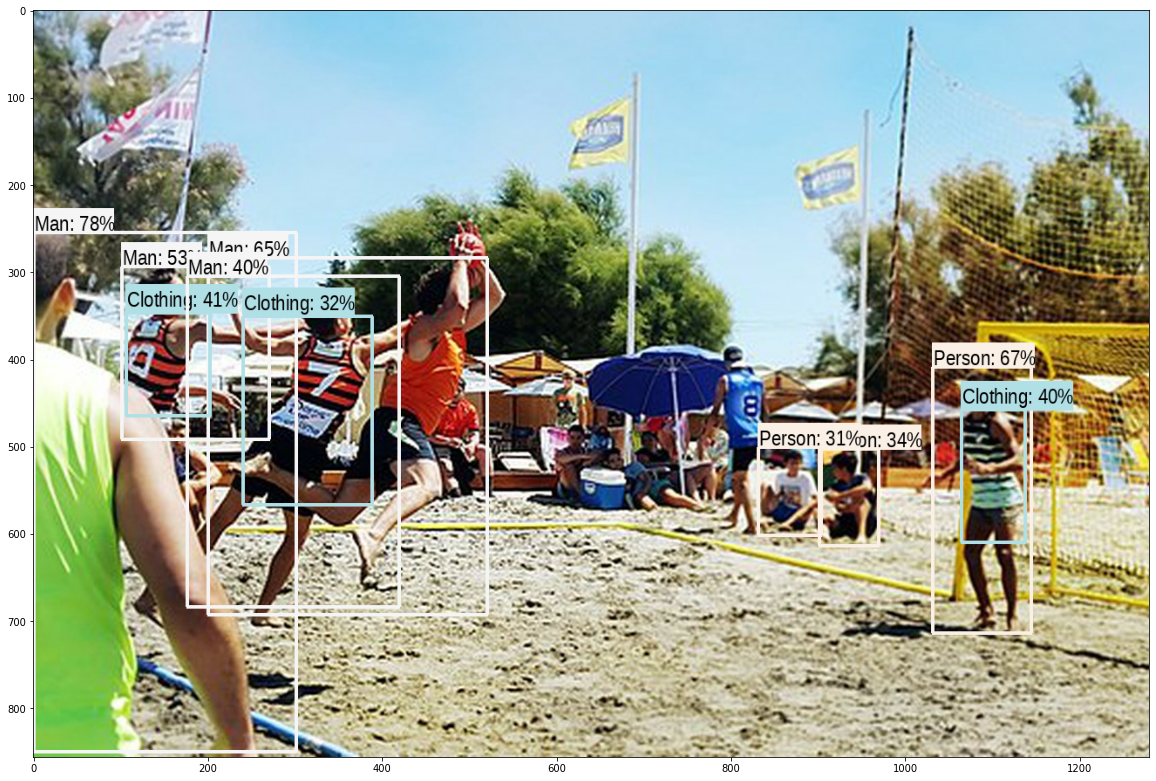

In [35]:
# detector를 실행
run_detector(detector, downloaded_image_path)

## 문제 2-1. 다른 이미지 테스트해보기

In [1]:
!pip install IPython

In [17]:
import os

# 1. 현재 디렉터리의 파일 목록 가져오기 (상대경로)
current_directory = os.getcwd()
file_list = os.listdir(current_directory)

# 2. 특정 디렉터리의 파일 목록 가져오기 (절대경로)
target_directory = '/Users/Kang/Desktop/'
file_list = os.listdir(target_directory)

# Image('/Users/youjin/Desktop/someday.jpg')

# 파일 목록 출력
print("Files in the current directory:")
for file_name in file_list:
    print(file_name)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Kang/Desktop/'

Image downloaded to /tmp/tmpzr_unfhz.jpg.


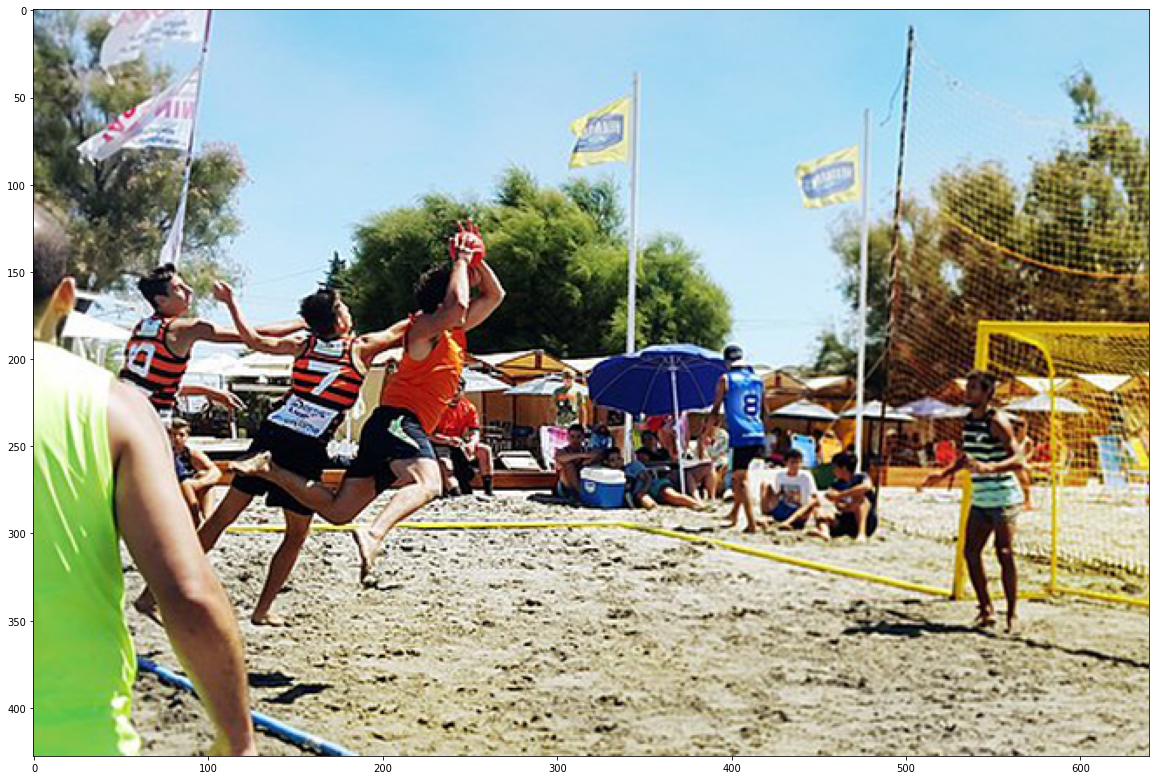

In [32]:
# 이미지 불러오기
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 640, 428, True)
# 이미지가 잘 불러와지지 않아 사이즈만 줄여봄

Found 100 objects.
Inference time:  67.36570119857788


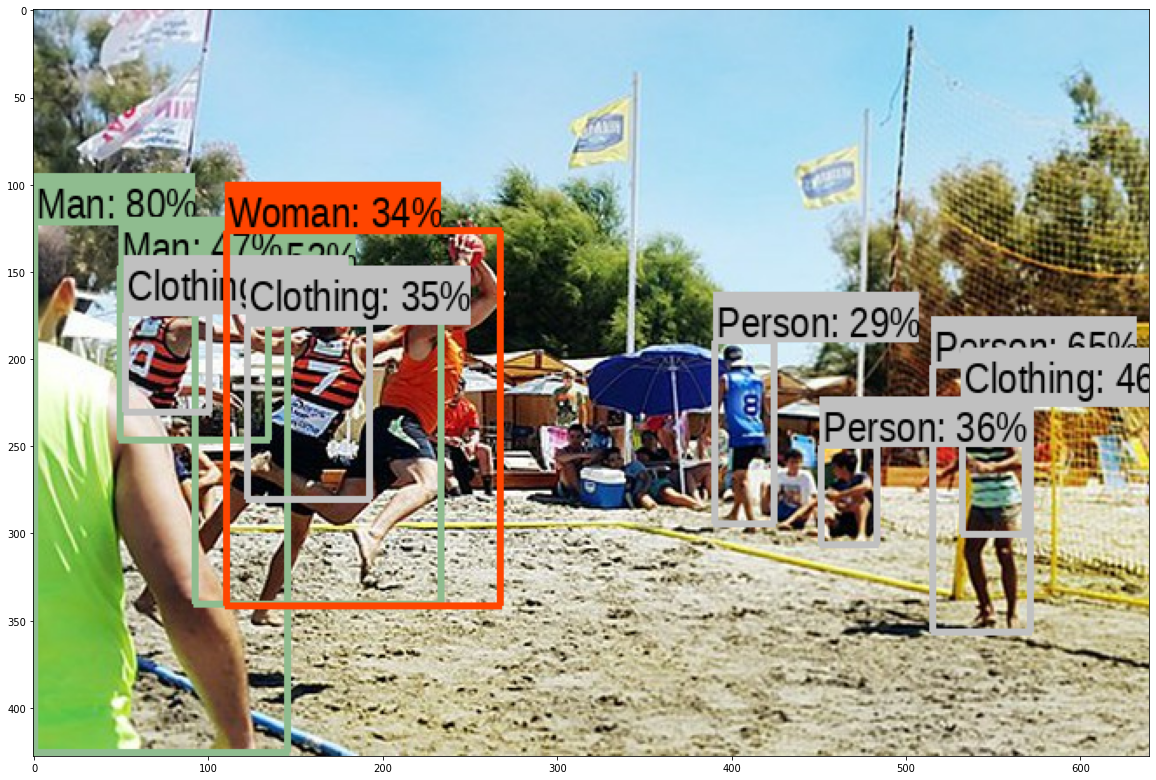

In [37]:
# 테스트
run_detector(detector, downloaded_image_path)

# 전체 회고

- 생각 만큼 프로젝트가 진행이 안돼서 갑갑했고 다음주에 쉬는 요일이 많은 만큼 처음 부터 찬찬히 다시 봐야 할 것같다...
- 돌아가지 않는 프로그램에 화가 나다가 왜 안되는지 해결 못하고 있는 나한테 화가 났다.
- 결국 남보다 학습속도가 느리면 그많큼 많이 하면 될거라 믿기에 계~속 진행 해야겠다.